# **HØVING VITBER**

**Abstract**

In this project we will utilize several numerical tools to study formations of membrane-less organells. We will be using some simple Monte Carlo simulations to illustrate how systemes of monomers and polymers will gradually develope over time. Our MC simulations will be following some basic physical principle to ensure a realistic model. We will also visualize the process to showcase different phenomenon, such as how monomers might consolidate into huge clusters and how polymers might adept their shape to best fit their enviromet. Thourghout the project we will also observe how energy will evolve and eventually oscillate around a equilibrium.

**Describing the system**

In our system we will simplify a plane to a 2-dimensional grid, meaning positions will be quantified. In these discrete system our meassure of distance and interaction inbetween monomers will also be simplified. If monomers are not neighbouring, they won't effect eachother. Even though there will be some kind of electrical force pulling and pushing monomers around, we will neglact this behavior. Moreover, our grid will be a relaitvly small representation of the entire cell. To ensure some realistic behavior "outside" the grid, we will assume the grid periodic. In practice this means our grid takes place on a geometric torus, looping around in all directions. Our unit step length will be $a = (23 \cdot 10^{-6})^2 m$ and $a = (91 \cdot 10^{-6})^2 m$ in the monomer and polymer case respectivly. The relativ permativity will be $\varepsilon_r = 78$ for both cases

When calculating energy, we will be using the usual superposition of electric potential. We will be looking at every potensial contribution seperatly and sum up to calculate the energy of the system. 

$$E = \sum_{i,j} V_{ij} \quad \quad V_{ij} = \frac{1}{4 \pi \varepsilon} \frac{q_i q_j}{|r_i - r_j|} $$

Since charge is quantified with the elementary charge we have

$$ q_i = w_i e, \quad w_i \in \mathbb{Z} $$

Which yields

$$V_{ij} = w_i w_j \frac{1}{4 \pi \varepsilon_0 \varepsilon_r} \frac{e^2}{|r_i - r_j|} = w_i w_j \frac{e^2}{4 \pi \varepsilon_0 \varepsilon_r a} \frac{a}{|r_i - r_j|}$$

Choosing 

$$\alpha = \frac{e^2}{4 \pi \varepsilon_0 \varepsilon_r a}$$ 


Due to that fact that only neighbours affect eachother, their distance $r = |r_i -r_j|$ will always be the unit length, namely $a$. Concluding 

$$
V_{ij} = \begin{cases}
             w_i w_j \alpha  & \text{if NN} \\
             0  & \text{else }
          \end{cases}
$$

For the system of monomers, charge value is been limited to $\pm 1$, and $w_i$ integer,  meaning energy will be given in quantified with $\alpha$.

$$E = \sum_{i,j} V_{ij} = \sum w_i w_j \alpha = \alpha \sum w_i w_j = \alpha z, \quad z\in\mathbb{Z}$$

**Physical priciples of our system**

To illustarte our system, we will be using the Metropolis algorithm. First we need to attempt a legal move. The law of conservation of energy will ensure that the system energy will diminish or stabilize. Thus, the first step will take meassures before and after, $E_0$ and $E_n$, to verify that the energy level of the successive system has declined. If the process succeeds, the move will be initiated. 

Although we want a converging system we will occasionally allow a "deviation". If a move failes the first step there will be a slim chance for the move to occur. The probability will be $e^{-\frac{\Delta E}{k_B T}}$. Thus we have an increasing and decreaising contribution which eventually converges. For higher temperature, thermal fluxuation is more probable.

**2g)**

While using the rigid move, the energy plot becomes more discrete. Also, the system maintains a constant energy level for longer periods of time. On the other hand, The medium-flexible move has a smoother energy graph. A higher percentages of the possible moves is allowed meaning the system is in constant state of change. In both cases, if the temperature is reasonable, the system will slowly move towards a system with one cluster. The flexible moves will most likely converge to a lower energy minima since polymer may deform to fit better with eachother.

**Difference in runtime**

in polymers, there is a huge number of moves which is illegal. When the MC-algorithm failes to make a move, we can sooner move to the next itterations. Therefore, it is much quicker. 

**Just in time**

While working through the project, some of the tasks expected an enormous amount of iterations to achive a reasonable sample space or decent data. Trying to write an efficient enough code proved quite hard. Our Monte Carlo simulation was not compatible  with a million iterations. Thus we tried to reach a higher potensial for the code. We have imported Numba JiT to decrease run time. The majority of the functions, escpacially those with longer chains of for-loop, have been JiTed. 

In the process of implementing Jit, we needed to change the code quite a lot. Numba Jit were only compatible with a handful of the functions we initially used. Jit are very comfortable with the standard library and parts of the numpy library. On a rare occasions some external functions were implemented, but the mindset of the function are very basic. One can say that the code is "better" since it runs faster, but elementary principles in coding theory are not followed. We have prioritized runtime over code quality for this project. 

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
import time
import copy
import matplotlib.ticker as ticker

from scipy.constants import Boltzmann, epsilon_0, elementary_charge
from itertools import chain
from matplotlib.colors import BoundaryNorm
from matplotlib.colors import ListedColormap,LinearSegmentedColormap, TwoSlopeNorm
from matplotlib import colors
from matplotlib import cm
from operator import indexOf
from sqlalchemy import distinct
from sympy import apart

from numba import jit
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

start_time = time.time()
epsilon_r = 78
a_mono = (23.e-6)**2
a_poly = (91.e-6)**2
alpha_mono = elementary_charge**2 /(4 * np.pi * epsilon_0 * epsilon_r * a_mono)
alpha_poly = alpha_mono * a_mono / a_poly

# 1AB

Before implementing Monte Carlo there is a lot of preperations needed. We will start by initiating our physical system which will be an $N\times N$ grid of integers. This matrix will work as our system of monomers in solvent. To quickly retract informations from our code we wanted to visulize these grids in an adequate way. 

In [2]:
@jit(nopython=True)
def createSystemOfMonomers(N, M):
    grid = np.zeros((N,N))                                                  #Initializing grid of size NxN with all coeffisients being zero

    distinctValues = np.arange(-M, M + 1)                                   #Initializing numpay array with evry integer between -M and M
    newDistinctValues = np.delete(distinctValues, M)                        #Deletes the element with index M, which is 0. 
    np.random.shuffle(newDistinctValues)                                    #Randomly shuffelig the distinct values of the monomer 

    count = 0

    while count < 2 * M:                                                    #Using the random library to place monomers with distinct values one by one
        x_value = random.randint(0, N-1)
        y_value = random.randint(0, N-1)

        if grid[y_value][x_value] == 0:
            grid[y_value][x_value] = newDistinctValues[count]
            count += 1

    locations = np.argwhere(grid)                                           #Returns an array with the coordinates of nonzero values 
                                                                            #of all the monomers in the grid
    return grid, locations                                              


def checkMonomers(grid, M):                                                 #Checking if system contains 2 x M monomeres
    nonZeroGrid = np.argwhere(grid)

    numberOfMonomers = len(list(nonZeroGrid))

    if numberOfMonomers == 2*M:
        print("Has 2M monomers in system")

    elif numberOfMonomers < 2*M:
        print("Has less than 2M monomers in system")
        
    else:
        print("Has more than 2M monomers in system")


def plotSystems(grids, info, title):
    numPlots = len(grids)
    a = (23.e-6)**2

    titleString = list()
    for i in range(0, numPlots):
        n = len(grids[i])
        titleString.append(info[0][i] + f", N = {n}")
        if info[1][i] != 0:
            titleString[i] += f", $N_s$ = {info[1][i]}"
        if info[2][i] != 0:
            titleString[i] += f", M = {info[2][i]}"
        if info[3][i] != 0:
            titleString[i] += f", T = {info[3][i]}"
        if info[4][i] != 0:
            titleString[i] += f", L = {info[4][i]}"

    if len(grids) == 1:
        fig, axs = plt.subplots(1,1, figsize=(8, 8))
        axs = [axs,axs]
    else:
        fig, axs = plt.subplots(1,numPlots, figsize=(7*numPlots, 7))
    fig.subplots_adjust(top=0.8, wspace=0.3)
    fig.suptitle(title, fontsize=16)

    backgroundColor = "paleturquoise"
    for i in range(0,numPlots):
        if info[5][i] == True:
            vnorm = TwoSlopeNorm(vcenter = 0.)
            grids[i] = np.ma.masked_where(grids[i] == 0., grids[i])
            cmap = cm.get_cmap("twilight_shifted").copy()
            cmap.set_bad(color=backgroundColor)
            im = axs[i].pcolormesh(grids[i][::-1], cmap=cmap, norm=vnorm)
        elif info[6][i] == True:
            a = (91.e-6)**2
            vnorm = TwoSlopeNorm(vcenter = 0.)
            grids[i] = np.ma.masked_where(grids[i] == 0., grids[i])
            cmap = cm.get_cmap("PRGn").copy()
            cmap.set_bad(color=backgroundColor)
            im = axs[i].pcolormesh(grids[i][::-1], cmap=cmap, norm=vnorm)
        else:
            cmap = colors.ListedColormap(["purple",backgroundColor,"g"])
            im = axs[i].pcolormesh(grids[i][::-1], vmin= -1, vmax= 1, cmap=cmap)

        axs[i].set_title(titleString[i])
        axs[i].set(xlabel=f"all units in a = {a}m")
    #fig.show()

The first algorithem, createSystemOfMonomers(N, M) takes two arguments: $N$ and $M$. These represent a given grid size and the amount of monomers, respectively.
The initilazation of an empty NxN grid is done by numpy.zeros([N,N]). Which creates an $N\times N$ grid with all zeros. Furthermore it creates an array containing all of the possible values of the monomers in the system i.e. [-M, -M+1, ..., 0, ..., M-1, M]. Since the solvent is given the value 0, numpy.delete() is used to remove 0 from the array containg the distinct values of the monomers. The sign of each of the values represent the electrostatic charge of each of the given monomers.

To provide a random grid of monomers the algorithm implements the numpy.random.shuffle() to make sure the distinct values will be placed arbitrary. 

The implementation of a while loop in conjuction with an if statement is done to assure no monomer is placed upon another. The random.randint() built in function is used to generate random pairs of coordinates which is to be considered for the placement of a monomer. If such a pair of coordinates is allready occupied by a monomer, the if statement inside the while loop assures the generation of another such pair until a legal placement is obtained.

When all of the monomers is placed in the grid, the function numpy.argwhere() returns an array containing the specific coordinates for the monomers in the grid. This array is sorted along the first axis.

The second algorithm, checkMonomers(grid, M), utilizes argwhere() to gather data on monomer positions. By checking the size of the returning array, the function can know how many monomers are placed. The functions confirmes or declines that the grid indeed contains $2M$ monomers, by printing an appropriate string. 


The third function, plotSystems(grids, info, title), is the plotting function. It takes in a list of grids, a 2d list of informantion and values for each grid, and the title for all plots. Firstly the functions initializes the number of grids to plot and the distance between each grid points for monomers. Secondly we create the title for each subplot; we add the subplot tile together with the value of $N$. From the 2d info list we get the values for $N_s$, $M$, $T$ and $L$. We add these to the subplot title if they are nonzero.

Furthermore the function create subplots for each grid by using plt.subplots(). When only creating one subplot, axs will be a single element and not a list. Therefore an exception is needed when plotting a single grid. Using figsize, subplots_adjust and suptitle we adjust the sizes and distanses between the subplots and add a title for the whole figure.

To be consistent with the example provided, the solvent is set to always be "Paleturquoise" There are three different ways to color the systems, either a clustered grid with distinct positive values, a polymer system with $M$ positive and $M$ negative polymers with shades of green and purple, or simple monomers with positive or negative charges, thus green and purple color. By altering the last arguments in "info" one can adjust the colors to best fit the system.

The result is a figure with up to four plots on line with their assigned relevant values above each subplot as well as the unit of measurement below.

Has 2M monomers in system


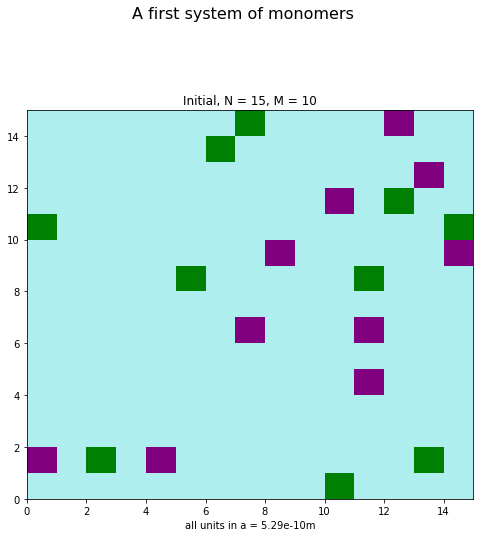

In [62]:
N = 15
M = 10

firstGrid, locations = createSystemOfMonomers(N, M)
checkMonomers(grid, M)

info = [["Initial"],[0],[M],[0],[0],[False],[False]]

plotSystems([firstGrid], info, "A first system of monomers")

This will work is our physical system. Green square are monomers with positive charge and vice versa for purple. The paleturquoise will showcase solvent positions in the cell.

# 1CDE

**Wind of change**


Thus far we have initialized a matrix of numbers, which represents our system of monomers, and an convenient way to visualize the grid. The next step is to turn this system into life by implementing the described Monte Carlo simuluation with the Metropolis algorithm. Some handy functions needed be defined beforehand. 

In [3]:
@jit(nopython=True)
def findNeighbours(N, y, x):                  
    neighbours = np.zeros((4,2))
    
    neighbours[0] = [int(y), int((x + 1) % N)]
    neighbours[1] = [int(y), int((x - 1) % N)]
    neighbours[2] = [int((y + 1) % N), int(x)]
    neighbours[3] = [int((y - 1) % N),int(x)] 
    
    return neighbours


@jit(nopython=True)
def totalEnergy(grid):
    N = len(grid)                                     
    energy = 0
                                                            
    locations = np.argwhere(grid != 0)

    for i in range(len(locations)):
        neighbours =  findNeighbours(N, locations[i][0], locations[i][1])
        
        for j in range(len(neighbours)):
            
            if grid[int(neighbours[j][0])][int(neighbours[j][1])] != 0:
                energy += np.sign(grid[int(locations[i][0])][int(locations[i][1])] * grid[int(neighbours[j][0])][int(neighbours[j][1])])

    return energy * alpha_mono / 2

    
@jit(nopython=True)
def move_monomer_fast(grid, monomer_value, direction):
    monomer_coordinates = np.argwhere(grid == monomer_value)[0]

    N = grid.shape[0]
    array_of_all_neighbor_coordinates = findNeighbours(N=N, y=monomer_coordinates[0],x=monomer_coordinates[1])
    
    desired_neigbor_coordinate = array_of_all_neighbor_coordinates[direction]

    if grid[int(desired_neigbor_coordinate[0])][int(desired_neigbor_coordinate[1])] == 0:
        grid[int(desired_neigbor_coordinate[0])][int(desired_neigbor_coordinate[1])] = monomer_value
        grid[int(monomer_coordinates[0])][int(monomer_coordinates[1])] = 0

        

@jit(nopython=True)
def MC(N_s, N, M, T, initGrid=None, initial=True):
    if initial == True:
        grid, locations = createSystemOfMonomers(N,M)
    else:
        grid = initGrid
        locations = np.argwhere(grid)
        
    initialGrid = np.copy(grid)
    typeMove = np.zeros(3)
    epsilon = np.zeros(N_s)

    EnergyOfState = totalEnergy(grid)

    epsilon[0] = EnergyOfState

    for i in range(N_s):
        oldGrid = grid.copy()
        
        choosenMonomer = 0

        while choosenMonomer == 0:
            choosenMonomer = np.random.randint(-M, M - 1)
                
        k = np.random.randint(0,3)

        move_monomer_fast(grid, choosenMonomer, k)

        EnergyOfState_new = totalEnergy(grid)

        if EnergyOfState_new < EnergyOfState:
            EnergyOfState = EnergyOfState_new
            typeMove[0] += 1
                            
        elif random.random() < np.exp(- (1 / (Boltzmann * T)) * (EnergyOfState_new - EnergyOfState)):  
            EnergyOfState = EnergyOfState_new
            typeMove[1] += 1

        else:
            grid = oldGrid.copy()
            typeMove[2] += 1
                    
        epsilon[i] = EnergyOfState
    
    return grid, epsilon, initialGrid, typeMove


findNeighbours(N, y, x) takes in $x$ and $y$ coordinates of a $N \times N$ grid and returns an array with the four neigbours. With the given coordinates, the function iterates through the right/left by shifting first index 1 value ([i $\pm$ 1, j]). Similarly for up and down. To make sure indecies won't exceed the grid range, the function "mods" out N in index entries, making the grid index loop around in all directions. The int() inside indecies makes it compatable with Numba JiT, since it doesn't suppert floats. 

totalEnergy(grid) returns a scalar value representing the energy state of the given grid argument. Using argwhere(), the funciton memorizes monomer locations. Iterating through every monomer, the function find their respective neighbours by findNeighbours(). If a given neighbour is a monomer, the code finds their signum value of the product of their number value in the grid. Lastly it sums all such contribution before returning. If monomers are neighbouring, both monomers will be iterated through. Both times their connection contribution are added, thus diving by $2$. Multiplication with $\alpha$ to convert the sum to SI. 
 

move_monomer_fast(grid, monomer_value, direction) uses argwhere() to find position of the monomer with the given monomer_value. After finding its array of neighbours, it determine the new position of the monomer by the direction value. If that new position is unoccupied, its value updates whilst the initial position expunges. A valuable remark might be how the functions never returns any grids, It just directily updates the value in the grid.

MC(N_s, N, M, T, initGrid=None, initial=True) is the funciton which executes steps in the grid. The arguments "initGrid" and "initial" are aguments given only when the Monte Carlo continues an already generated system of monomers. The if-else checks whether it shall continue or make a new system of monomers. To plot initial grid in the end, initialGrid copys the given grid argument. MC() also makes an array to keep track of the energy progression. 

For convenience reasons later, the function saves a copy of a grid before a move has been initiated. By randomly choosing a grid position untill the value is nonzero, the function finds a random monomer. Then randomly finding a number between $0$ and $3$ which determine a direction for the monomer. With move_monomer_fast() and totalEnergy() the function executes the move, gives an possible updated grid and calulates energy before and after. The If-elif-else chain goes thorugh the Metropolis algorithm. If the move suceeds, the updated grid becomes the new grid, else the function reverts the move by setting the grid equal the copied grid. The energy of the current grid is now extracted. MC() initiates a monomer move $N_s$ times, finally returning initial and final grid alongside an energy array.

np.copy(grid) and grid.copy() allocation new memory. After using the usual "$b$ = $a$", variables may still be dependet by some memory alocation problem. Whilst changing up $b$, $a$ might also alter in the porcess. By giving such variables completely different memory, by some copy function, one can avoid such problems.

In the Monte Carlo simulations there is a chance for monomers to advance to a higher energy state. This probability, if first step is rejected, is given by $e^{-\frac{\Delta E}{k_B T}}$. If the monomer where to find a move which maintains the energy level, this probability will be 1. We have included this senario in our simulations to make the system more fluid. For reasons described later in the project, it is ideal to have an active system. Fewer iterations are needed inbetween systems to make grids "independet". Also we want "lonely" monomers to have a chance to move.

In [63]:
print("The energy of the firstGrid is: ", totalEnergy(firstGrid), " J")

The energy of the firstGrid is:  0.0  J


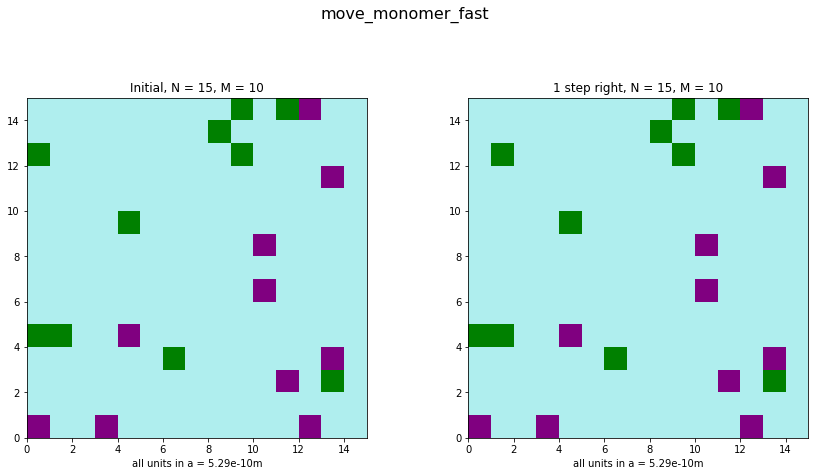

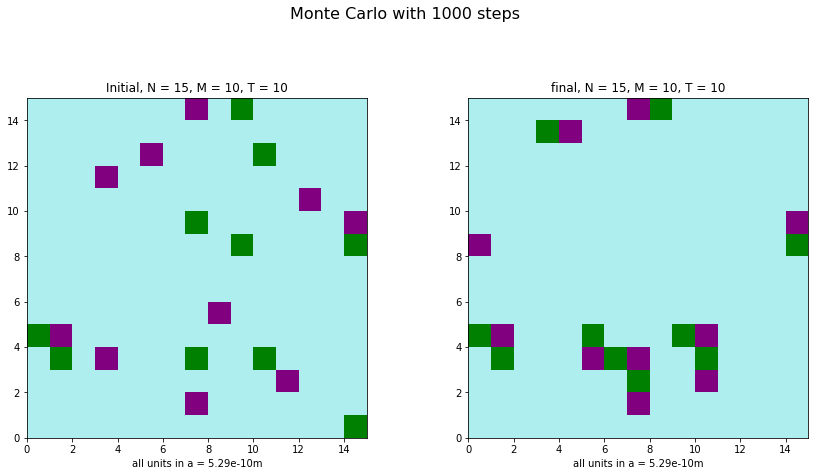

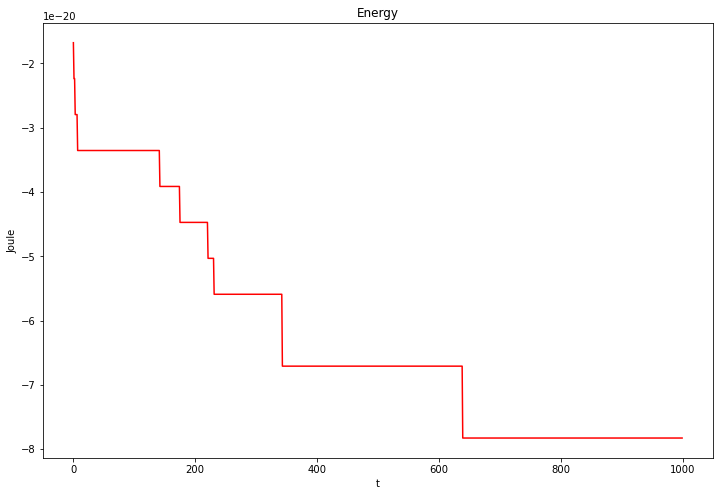

In [5]:
N = 15
M = 10
T = 10
N_s = 1000

grid, locations = createSystemOfMonomers(N, M)
initialGrid = grid.copy()
move_monomer_fast(grid, 1, 0)

grids = [initialGrid, grid]
info = [["Initial", "1 step right"],[0,0],[M,M],[0,0],[0,0],[False,False],[False,False]]
plotSystems(grids, info, "move_monomer_fast")

grid, epsilon, initialGrid, typeMove = MC(N_s, N, M, T)

grids = [initialGrid, grid]
info = [["Initial", "final"],[0,0],[M,M],[T,T],[0,0],[False,False],[False,False]]
plotSystems(grids, info, "Monte Carlo with " + f"{N_s} steps")

t = np.linspace(0, len(epsilon) - 1, len(epsilon))

plt.figure(figsize=(12,8))
plt.title("Energy")
plt.plot(t, epsilon, "r", label = "yey")
plt.xlabel("t")
plt.ylabel("Joule")
plt.show()

The first plots ilustrate a right move in the leftmost green monomer. The middle plots showcases an intial system of monomer and the result after iterating $1000$ moves. The latter graph ilustrates how energy varies through the iterations in the given system of monomers.


# 1F

Now we want to examine how our Monte Carlo algorithm tranforms random systems of monomers. We will run two different simulations with different temperatures to compare different size. We have choosen $T_1 = 200 K$ and $T_2 = 500 K$ for testing purpose even though these numbers are unatural from a biological point of view. Thorughout the course of the Monte Carlo we will keep an eye on how energy develops over time.

In [4]:
def plotEnergy(epsilon, title, n_s=0, m=0, t=0, l=0, comparison=False, epsilon2=0, t2=0, move="", move2=""):
    t_val = np.linspace(0, len(epsilon) , len(epsilon))                         #Values for x axis
    n = len(grid)                                                               #Length of grid

    titleString = title + f", N = {n}"                                          #Main subplot title

    if comparison == True:                                                      #Adding specific title for comparison plots
        if t2 == 0:
            titleString = f"Comparison between {move} and {move2} moves"        #Comparing different move types
        else:
            titleString = f"Comparison between $T_1$ = {t} and $T_2$ = {t2}"    #Comparing different temperatures
    if n_s != 0:
        titleString += f", $N_s$ = {n_s}"                                       #Adding N_s to subplot title
    if m != 0:
        titleString += f", M = {m}"                                             #Adding M to subplot title
    if t != 0 and comparison == False:
        titleString += f", T = {t}"                                             #Adding T to subplot title
    if l != 0:
        titleString += f", L = {l}"                                             #Adding L to subplot title

    if comparison == False:                                                     #Adding E_t to subplot title if not comparing
        label1 = f"$E_{{{t}}}$(t)"                                              
    else:                                                                       
        if t2 == 0:
            label1 = f"$E_{{{move}}}$(t)"                                       #Adding E_move1 and E_move2 for comparing plots between different movements
            label2 = f"$E_{{{move2}}}$(t)"
        else:
            label1 = f"$E_{{{t}}}$(t)"                                          #Adding E_t1 and E_t2 for comparing plots between different temperatures
            label2 = f"$E_{{{t2}}}$(t)"

    plt.figure(figsize=(12,8))                                                  #Increasing figure size
    plt.title(titleString)                                                      #Adding main title
    plt.plot(t_val, epsilon, "r", label=label1)                                 #Plotting energy development
    if comparison == True: 
        plt.plot(t_val, epsilon2, "b", label=label2)                             #Plotting energy development for comparing
        plt.legend()                                                            #Adding legend to see wgho belongs to what
    plt.xlabel("t")
    plt.ylabel("Joule")
    plt.show()

plotEnergy() is a fairly simple function for its sheer length. The functions creates an array with integers with the same length as epsilon. Since epsilon include the initial energy level, its length are $1$ bigger than amount of iterations. Meaning every the $i$-th energy has index position $i$. Therefore the second argument in linspace subtracts 1. The plots visualizes by utilizing some standard matplotlib.pyplot functions. 

#Alex med noen kjappe kommentarer om hvordan den funker

To make sure we are just varying $1$ parameter at the time, we will be using the same initial position for both temperatures. 

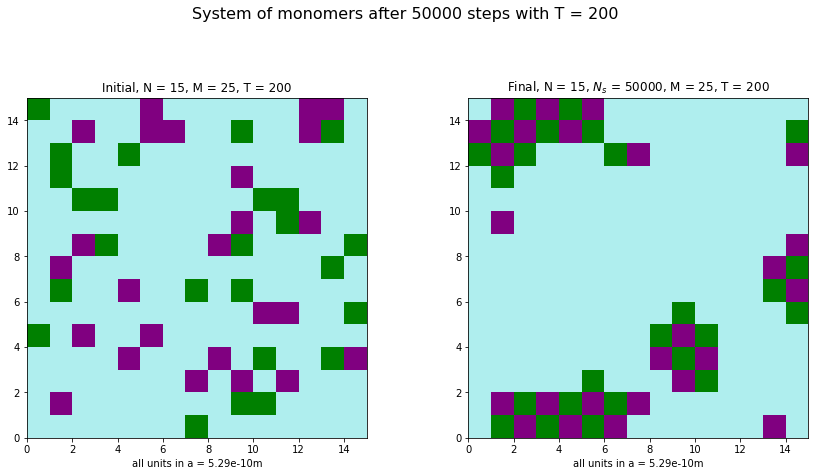

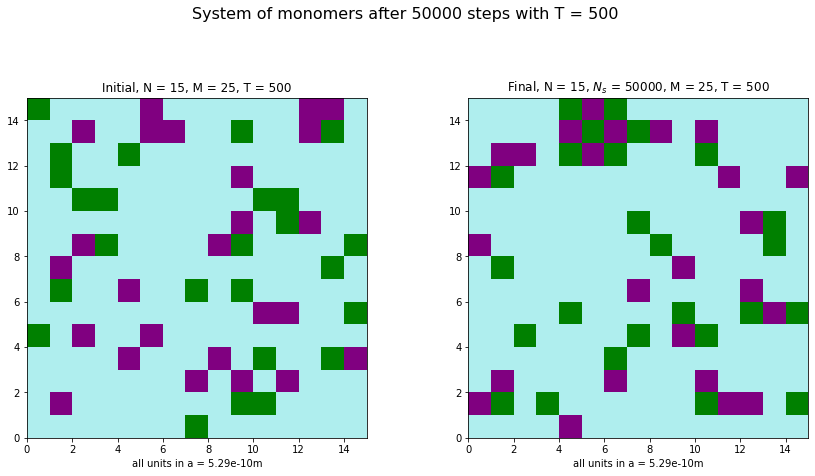

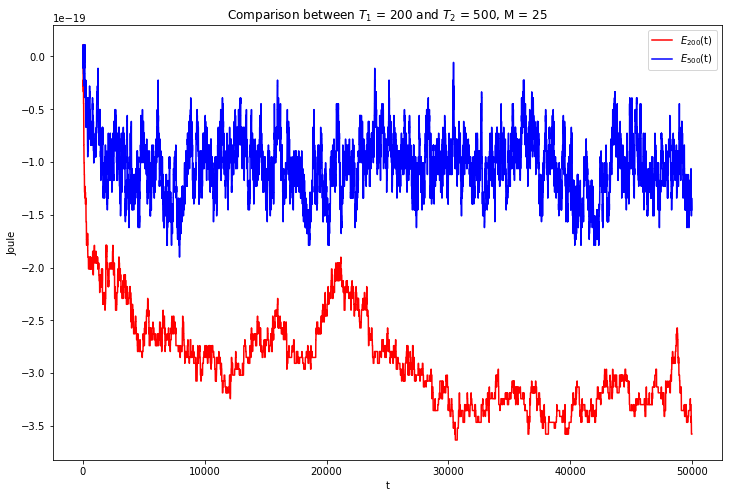

In [7]:
N_s =50000
N = 15
M = 25


T1 = 200

grid_200, epsilon_200, initialGrid_200, typeMove_200 = MC(N_s, N, M, T1)
grids = [initialGrid_200, grid_200]
info = [["Initial", "Final"],[0, N_s],[M, M],[T1, T1],[0, 0],[False, False],[False, False]]
plotSystems(grids, info, f"System of monomers after {N_s} steps with T = {T1}")

T2 = 500

grid_500, epsilon_500, initialGrid_500, typeMove_500 = MC(N_s, N, M, T2, initGrid = initialGrid_200, initial=False)
grids = [initialGrid_500, grid_500]
info = [["Initial", "Final"],[0, N_s],[M, M],[T2, T2],[0, 0],[False, False],[False, False]]
plotSystems(grids, info, f"System of monomers after {N_s} steps with T = {T2}")

plotEnergy(epsilon_200, "Energy comparison", m=M, t=T1, comparison=True, epsilon2=epsilon_500, t2=T2)

Inspection of the energy plot instantly gives that the energy of system of monomers decrease when temperature falls. The final plots displays why it is the case. For lower temperature, monomers prefers to group together with their opposite charge. Green monomers want purple neighbours, making a chess board grid. For the higher temperture the grouping phenomenon still happens, but not as frequent .

These are a direct consequence of the metropolis algorithm. In a scalding enviroment monomers are more exposed to thermal fluxuation. In our model, the probability of a monomer moving to a higher energy state is given by $P(A)=e^{-\frac{\Delta E}{k_B T}}$ (If it didn't move to a lower state). Larger values of $T$ makes a total energy increase more likely. Moreover, in a freezing enviroment an increase in total energy is quite rare. We expect that higher temperatures will fluxuate around a higher energy level, which is illustrated in our plots.

One can also observe that $t_{equil}$ is massive for small temperatures. An explaination might be that system with low temperatures are bearly active. The chances to increase system energy are slim whilst temperature is meager, thus the system may get stuck in a local minimum. To circumvent such behaviors, a lucky sequence of fluxuation may be neccessary to proceed. However, such chains are few and far between, indicating an enormous amount of iterations required to acchive equilibrium.

An important remark is how energy for higher temperatures showcases more frenzy, supporting the fact that such systems are highly active. Even though the energy occilates around a mean, its "amplitide" is quick large. 

In our plot, the energy for the system of monomers in the freezing enviroment has a decreasing trend all the way, indicating that it yet has to reach its equilibrium. This supports our theory that lower temperatures need alot of iterations. In the scalding enviroment the energy seems to start to fluxuate around a stable value quickly. Already $10000$ iterations in the energy occilates. 

A possible explaination is a combination of the high equilibrium energy and that higher temperature have an larger "interval of equilibrium". In some sense the initial grid start within the equilibrium range. Thus needing few moves to reach it. 

# 1G

The previous plots showcased some kind of grouping of monomers, now we want to study it further. Thus far it seems as though lower temperatures gives huge clusters of monomers. To verify our hypothesis we will try finding a how clustering changing with temperature. First we need to implement some functions. 

In [5]:
@jit(nopython=True)
def cluster(clusterGrid, N, k):
    clusterGrid = clusterGrid.copy()
    #clusterGrid = clusterGrid.astype(np.int64)
    locationsOfMonomers = np.argwhere(clusterGrid)
    
    if k < len(locationsOfMonomers):
        neighborsOfK = findNeighbours(N, locationsOfMonomers[k][0], locationsOfMonomers[k][1]).astype(np.int64)
        
        for element in neighborsOfK:
            for i in range(len(locationsOfMonomers)):
                if np.array_equal(locationsOfMonomers[i], element):
                    clusterGrid = np.where(int(clusterGrid[int(element[0])][int(element[1])]) != clusterGrid, clusterGrid, clusterGrid[int(locationsOfMonomers[k][0])][int(locationsOfMonomers[k][1])])

        return cluster(clusterGrid, N, k + 1)
    
    for i in range(-M, M):
        if i != 0:
            clusterGrid  = np.where(i != clusterGrid, clusterGrid, M + 10 * i)

    clusterNumbers = np.unique(clusterGrid)
    numberOfClusters = len(clusterNumbers) - 1

    sizes = np.zeros(numberOfClusters + 1)
    for i in range(len(clusterNumbers)):
        for location in locationsOfMonomers:
            if int(clusterGrid[int(location[0])][int(location[1])]) == int(clusterNumbers[i]):
                sizes[i] += 1

    return clusterGrid, numberOfClusters, sizes

Cluster(clusterGrid, N, k) is a recursive functon, taking three arguments, the grid we want to modify, the grid size $N$ and the number of recursive steps in which the function already has preformed $k$.

Every recursive step begins with the copying of the grid created by the last recursive step. Furthermore numpy.argwhere() is used to create a 2D array of the coordinates of the given monomers in the grid.

The if-statement k $<$ len(locationsOfMonomers), assures that the amount of recursive steps done is no more than the amount of monomers in the grid. Whilst this assumption holds the function creats an array of the four nearest neighbours of the k-th monomer in the system. For each of these neighbouring locations it checks whether or not the location is already occupied by a monomer, by use of the numpy.array_equal() functon. If one of these neighbouring positions is allready occupied by a monomer, every monomer with the same specific value needs to be assigned the value of the k-th monomer. This is accomplished by numpy.where() which takes a specific value as input and changes each occurrence of this value into a new one.  

This modified grid is then used as an argument when the function is run anew, this time with k = k + 1.

When all of the recursive steps are run. The grid needs to be modified such that each cluster is assigend a unique positive value. This is done by a the use of a for-loop in conjuncion with np.where(). The if-statement is used to ensure the algorithem does not change the value of the solvent.

np.unique(clusterGrid) returns an array containing each unique value in the grid. The value of the solvent, i.e zero, is also represented in this array. Therefore the amount of clusters in the grid can be obtained by reducing the length of this array by one, i.e len(clusterNumbers) - 1.

For practical purposes the function should return an array containg the size of each of the clusters. To create this array the algorithem initiates an array of zeros with the same lenght as the array created by the np.unique() function. Furthermore the function runs through every value in the array containing the cluster numbers. For each of these values the algorithem checks whether or not each of the monomers in the grid is assigned the given cluster number. For every monomers which is assigned the cluster number of interest, the array containing the sizes is updated. The element in the array which is supposed to represent the amount of zeros in the grid will be set to zero since none of these coordinates is represented in the array containg the positions of monomers.

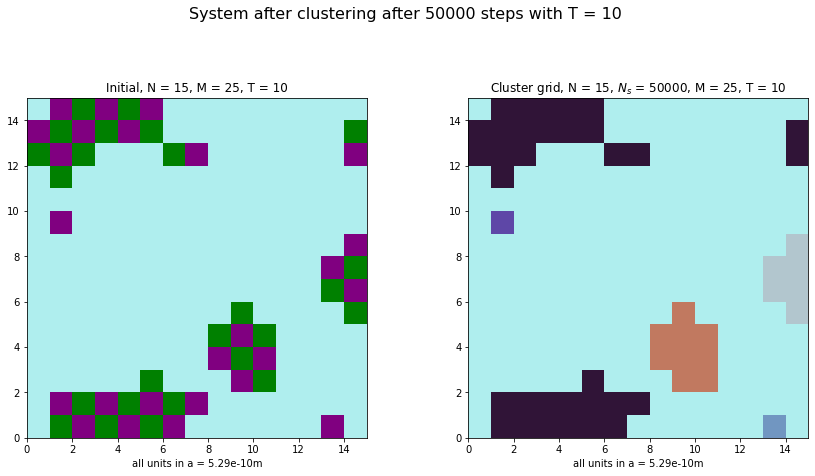

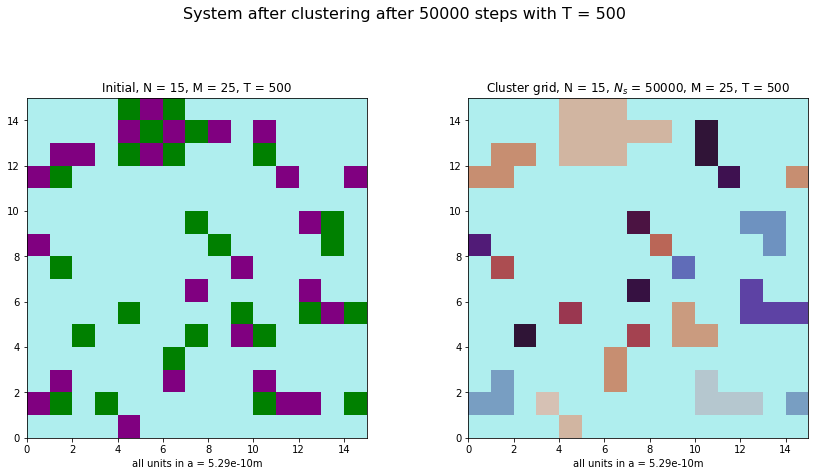

In [9]:
clusterGrid_200, numberOfClusters_200, clusterSizes_200 = cluster(grid_200, 15, 0)
grids = [grid_200, clusterGrid_200]
info = [["Initial", "Cluster grid"],[0, N_s],[M, M],[T, T],[0, 0],[False, True],[False, False]]
plotSystems(grids, info, f"System after clustering after {N_s} steps with T = {T}")


clusterGrid_500, numberOfClusters_500, clusterSizes_500 = cluster(grid_500, 15, 0)
grids = [grid_500, clusterGrid_500]
info = [["Initial", "Cluster grid"],[0, N_s],[M, M],[T2, T2],[0, 0],[False, True],[False, False]]
plotSystems(grids, info, f"System after clustering after {N_s} steps with T = {T2}")

The above plots shows the formations of aggregats after our first MC-simulations. The plots indicated some close relationship between amount of clusters and temperature. Thus far it seems as though lower temperatures gives bigger and few clusters and vice verse for higher temperatures. To further pursue this correlation we will implement a function which runs multiple consecutive simulations for different tempertures. After reaching equilibrium we will gather information about clustersizes. 


Since there were too many unknown variables, we were unable to find $\langle d \rangle$ analytic. Through our simulations we found some empiric values to give an estimate for the expected value. We consider multiple estimators and found that mean of mean to be our best estimator. We will include some rigorous calculations to justify our choice of estimator. 

Both mean ($\hat \mu$) and double mean ($\tilde \mu$) are unbiased estimators of the expected value.
$$
\begin{align*}
E[\hat \mu] &= E \bigg[ \frac{1}{n} \sum_{i=1}^n x_i \bigg] = \frac{1}{n} \sum_{i=1}^n E[x_i] = \frac{1}{n} \sum_{i=1}^n \mu = \mu \\
E[\tilde \mu] &= E \bigg[ \frac{1}{n} \sum_{i=1}^{n} \frac{1}{m_i} \sum_{j=1}^{m_i} x_j \bigg] = \frac{1}{n}  \sum_{i=1}^{n} \frac{1}{m_i} \sum_{j=1}^{m_i} E[x_j] = \frac{1}{n} \sum_{i=1}^{n} \frac{m_i}{m_i}\mu = \frac{n}{n} \mu = \mu \\
\end{align*}
$$
however, the variance of the double mean ilustrates that the estimator gives a more precise estimate. 

$$
\begin{align*}
Var[\hat \mu] &= Var \bigg[ \frac{1}{n} \sum_{i=1}^{n} x_i \bigg] = \frac{1}{n^{2}} \sum_{i=1}^{n} Var[x_i] = \frac{1}{n^{2}} \sum_{i=1}^{n} \sigma^{2} = \frac{\sigma^{2}}{n} \\
Var[\tilde \mu] &= Var \bigg[ \frac{1}{n} \sum_{i=1}^{n} \frac{1}{m_i} \sum_{j=1}^{m_i} x_j \bigg] = \frac{1}{n^2}  \sum_{i=1}^{n} \frac{1}{m_i^2} \sum_{j=1}^{m_i} Var[x_j] = \frac{1}{n^2} \sum_{i=1}^{n} \frac{1}{m_i}\sigma^2 = \frac{\sigma^2}{n^2} \big(\frac{1}{m_1} + \frac{1}{m_2} + ... \frac{1}{m_n}\big) \leq^{*} \frac{\sigma^2}{n} \\
\end{align*}
$$
and our claim follows

Throughout the proof, we have assumed independency of the random variables. In * every fraction $\frac{1}{m_i} \leq 1$, since $m_i \in \mathbb{N}$. Therefore, the sum of $n$ such quotions must be smaller or equal to $n$. In practice, for reasonable temperatures, the system prefers mulitple clusters, meaning there is a considerable differance in variance.


To study how monomers behave after the system fluzuate around it's equilibrium, we need som kind of way to determine when a system has reached its state of stability. Our optimistic procedure will be to predict a reasonable number of iterations are neccessary for a given a temperature. By assignment

$$t_{equil}(T) = t_{max} e^{-s(T-T_l)} + C, \quad \textrm{for } T \in [100, 1000]$$

Where $s = \frac{1}{200}$, $t_{max} = 100000$, $C = 10000$, $T_l = 100 K$

After reaching the equilibrium we will iterate $t_r = 1000$ times inbetween each sample. By assignment, $1000$ iterations will be large enough to assume grids independet. We will be choosing $n=385$, giving us a large sample space. 

A common formula for finding sample size (SS) for infinite sample spaces is given by $$SS = \frac{Z^2 p(p-1)}{M^2}$$, where $Z$ represents the score of the confidence level, $M$ is margin of error and $p$ is the population proportion. Since we have no idea what the $p$ is we will just assume it be $0.5$ since it gives the largest value. Plugging in $Z = 1.96$ which is the confidence score for $95$% and $M = 0.5$ gives that the sample space should be $384.16$ and our choice of $n$ follows. 


We are well awere that this model holds some disadvantages. After a spesific number of iteration, there is never a warranty that equilibrium is reached. Some initial grid may need alot more iteraions to get ready. Such systems gives "early samples" which may skew our results.


Our algorithem is presented below.

# 1H

In [6]:
from statistics import mean

t_max = 100000
s = 1/200
C = 10000

def t_equili(T, T_l):
    return int(t_max * np.exp(- s * (T - T_l)) + C)


def meanSize(N, M, T0, T1, n):
    t_r = 1000
    T = np.linspace(T0, T1, 10)
    meanSize_t = list()
    meanSTD_t = list() 
    diff_t = list()

    for t in T:
        t_eq = t_equili(t, T0)
        N_s = t_eq + t_r * n

        grid_eq, epsilon_eq, initialGrid, typeMove = MC(t_eq, N, M, t)

        grid_i = grid_eq
        meanSize_i = list()
        for i in range(n):
            grid_i, epsilon_i, initialGrid, typeMove = MC(t_r, N, M, t, initGrid=grid_i, initial=False)

            grid_i = copy.copy(grid_i)
            
            clusterGrid, numberOfClusters, sizes = cluster(grid_i, N, 0)

            meanSize_i.append(sum(sizes)/numberOfClusters)
        diff_t.append(np.amax(meanSize_i) - mean(meanSize_i))
        meanSTD_t.append(np.std(meanSize_i))
        meanSize_t.append(mean(meanSize_i))

    return T, meanSize_t, meanSTD_t, diff_t

$t_{equil}(T, T_l)$ takes two arguments, the given temperature we want to consider, $T$, and the lowest temperature we consider in our sample, $T_l$. The resulting value is the amount of time steps needed to reach equlibrium, considering our above model.

The function meanSize(N, M, T0, T1, n) takes five arguments, the grid size, $N$, the amount of monomers in the system, $M$, the lowest and highest temperatures we want to consider, T0 and T1, respectivly, and $n$, the amount of meassurments we want to do while considering a given temperature.

The function starts of defining $t_r$, the amount of MC steps required for two grids to be considered independent. Further the function creates an array of ten evenly spaced temperatures between the T0 and T1. This is done by using numpy.linspace() function. From here, the algorithem initiates an empty list which consecuently is to be updated with estimates of the expected cluster size for the given temperatures.

A for-loop is used to run through each of the temperatures that is to be considered. For each of these temperatures t_equili is used to return the amount of Monte Carlo steps required to reach equilibrium for the given temperature. Furthermore the MC algorithem is used to initiate a grid and runs a simulation until the system reaches equilibrium.

From here we implement our double mean estimator by initiating an empty list which in the end will contain the mean cluster size for each of the grids we meassure for a given temperature. 

To make n measurments a for-loop is used. For every computation the algorithem run t_r MC-steps on the grid that was lastly modefied. Further it uses the cluster algorithem to return the number of clusters in the grid and the size of these clusters. From here the function computes the mean of the array containg the cluster sizes. Since the array containing sizes contains an additional zero, the mean can be computed using the built in sum() function and further deviding this sum by the amount of clusters in the grid. This value is appended to the list containing the mean cluster sizes for the given temperatur. When n such values is appended to the list. The function mean() is used to calculate the mean of the n meassurments done for each temperature. This mean value is appended to the list containg our estimate for the expected cluster size. When this is done for every temperature, the list containg every estimate is returned.

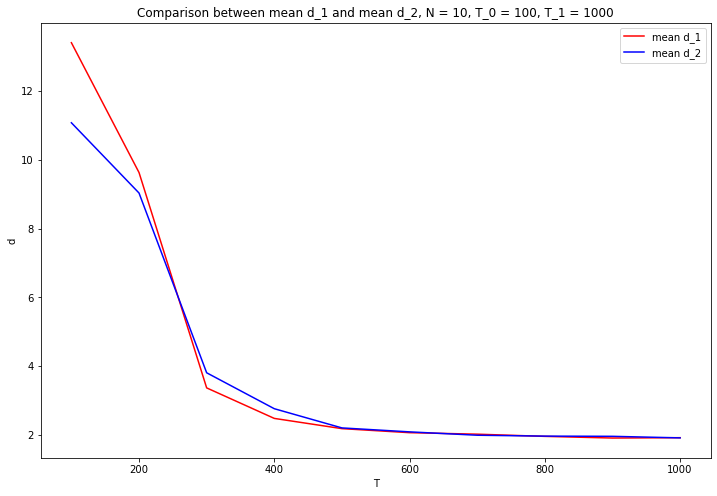

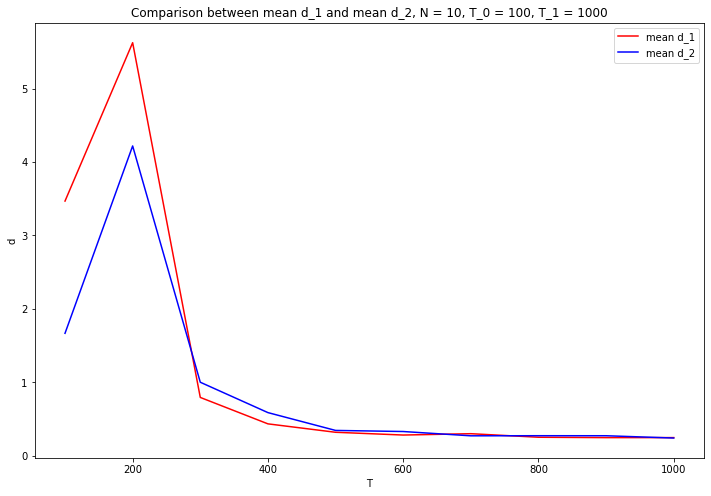

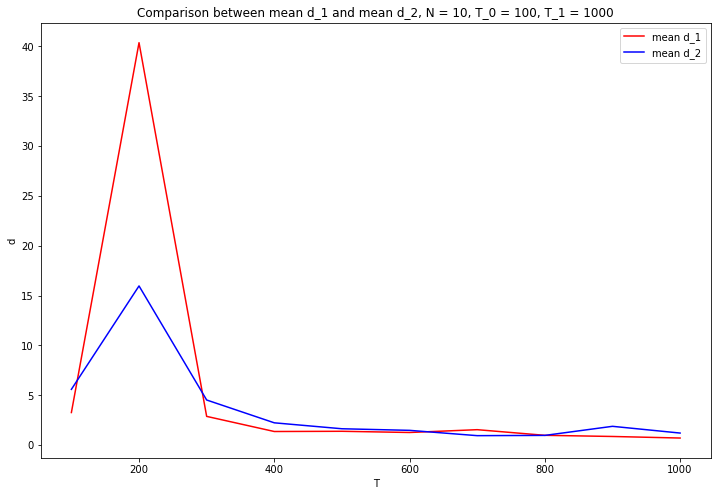

In [78]:

def compareMeanSize(d1, d2, t0, t1, title):                            
    t_val = np.linspace(t0, t1, 10)
    n = len(grid)

    titleString = "Comparison between mean d_1 and mean d_2" + f", N = 10, T_0 = 100, T_1 = 1000"

    plt.figure(figsize=(12,8))
    plt.title(titleString)
    plt.plot(t_val, d1, "r", label="mean d_1")
    plt.plot(t_val, d2, "b", label="mean d_2")
    plt.legend()
    plt.xlabel("T")
    plt.ylabel("d")
    plt.show()

n = 385
N = 15
M = 25
T0 = 100
T1 = 1000

T, d, std, diff = meanSize(N, M, T0, T1, n)
T_2, d_2, std_2, diff_2 = meanSize(N, M, T0, T1, n)

compareMeanSize(d, d_2, T0, T1, "Comparison of mean d ")

compareMeanSize(std, std_2, T0, T1, "Comparison of SD")

compareMeanSize(diff, diff_2, T0, T1, "Comparison of difference to extremne value")


From our plots indicates that our intiuation were true, giving a monotonic decrease with cluster size with respect to temperature. As we have seen before, freezing enviroments will fluxuate around a low energy state. Opposite neighbour charges gives the highest negativ energy contribution, meaning monomers is merged together like a chess board grid. Such systems will only have a few such blobes, meaning the cluster sizes will be enormous. Our graphs illustraed our presumption quite well. 


Whilst we only present a single final plot, the graph structure is consistent. By empiric results and by the calculation we did earlier we will deem our $n$ representative. 

As earlier mentioned, there is never a garantee that we have reached the equilibrium after a set number of iterations, especially for lower temperatures. "Good" initial grid may be very significant to take representative samples after $t_{equil}$ iterations. Consecutive early samples may skew the results. This is only a concern for small temperatures since hotter enviroments reach equildirum quickly.

A surprising result might be the difference between the mean value and the extreme value for $T = 100$ was lower than expected. A natural prediction was a hyperbola, but the tiny deviation from the mean in the coldest enviroment was unexpected. 

We see that the for colder values of temperature the $\langle d \rangle$ varied the most. Our suspicion is that the discrepancy is due to the importance of initial positions of the monomers for lower temperatures. It is closly related to the $t_{equil}$ and the fact that we have no guarantee we have reached it.

# Polymer

Monomers often combine with eachother to make bigger structurs, namely polymers. By covalent bonds, monomers of the same charge may amalgamate into huge blobs. We will now turn our attention into those structures. 

Our system will slightly differ from our monomer case. Our initial length will, by assignment, will be $a = (91.e-6)^2 m$. the releativ permativity will be presserved. $\varepsilon_r = 78$

There will also be some minor change ups while calculating energy of polymers. Polymers will operate as single organisms. While caluclating energy for polymer, we will be using the same model for energy contribution between monomers which neighbour a monomer from another polymer. Monomers within the same polymer will play no part in our energy calculation.

Before studying such systems we need some way to generate grids to represent polymers in solvent. We revised our createSystemOfMonomers() and changed up some simple argument, of which we added an argument for multivalency L, to make it initiate polymers instead. $L$ will represent how many monomers fill a polymer. For simplisity, we will assume polymer size invariant. 

In [7]:
def illegalPlacement(x, y, grid):                                                       #Function returnning whether or not a location is already 
    if grid[y][x] != 0:                                                                 #occupied by a monomer
        return True
    else:
        return False                                                                                  
   
def randomMonomer(N):                                                                   #Function returning a random set of coordinates in a grid of size NxN
    return random.randint(0, N-1), random.randint(0, N-1)

def findRandomNeighbor(existingPositions, N, grid):                                     #Function returning a random set of coordinates in which a given polymer is to be expanded to
    allowedPositions = list()                                                          
    for i in range(len(existingPositions)):                                              #existingPositions contains coordinates for evry monomer in a given polymer
                                                                                         #each non occupied neighboring position is added to a list of allowed positions
        x, y = existingPositions[i]
        if grid[y][(x + 1)%N] == 0:
            allowedPositions.append([(x + 1)%N, y])
        if grid[y][(x - 1)%N] == 0:
            allowedPositions.append([(x - 1)%N, y])
        if grid[(y + 1)%N][x] == 0:
            allowedPositions.append([x, (y + 1)%N])
        if grid[(y - 1)%N][x] == 0:
            allowedPositions.append([x, (y - 1)%N])
  
    uniqueAllowedPositions = [] # Removes duplicates
    for item in allowedPositions: 
        if item not in uniqueAllowedPositions:
            uniqueAllowedPositions.append(item)

    randomIndex = random.randint(0, len(uniqueAllowedPositions)-1)                         #One random  position is chosen out of these unique positions
    x, y = uniqueAllowedPositions[randomIndex]
    return x, y


def createSystemOfPolymers(N, M, L):                                                       #Algorithem returning a grid containing a polymer system
    grid = np.zeros([N, N])                                                                #Initializing a empty grid of size NxN
    unique_M = chain(range(-M, 0), range(1, M+1))                                          #Creating a list of integers between -M and M, excluding zero.

    for i in unique_M:                                                                     #Initializing the construction of polymer number i in unique_M
        ran_x, ran_y = randomMonomer(N)
        while illegalPlacement(ran_x, ran_y, grid):
            ran_x, ran_y = randomMonomer(N)
        
        randomPosition = [ran_x, ran_y]
        grid[ran_y][ran_x] = i
        
        monomerPositionArray = list()
        monomerPositionArray.append(randomPosition)
          
        for j in range(1, L):                                                               #Placing L - 1 monomers to form a polymer.
            try:                                                                            #Using try and except statement to avoid the formation of a polymer 
                x, y = findRandomNeighbor(monomerPositionArray, N, grid)                    #in wich L monomers cannot be forged
            except ValueError:
                print("fail")
                return createSystemOfPolymers(N,M,L)
            
            monomerPositionArray.append([x, y])
            grid[y][x] = i
    return grid

The function illegalPlacement(x, y, grid) takes x and y coordinates and a given grid of interest as input. The function uses an if-else statement to check wheter or not the given coordinates is already occupied by a monomer. If the location is already occupied the function returns True, whilst the function returns False in the opposite scenario.

randomMonomer(N) returns x and y coordinates each being a random integer on the intervall [0, N-1].

findRandomNeighbor(existingPositions, N, grid) is the function which locates a position in which a given polymer under construction is to expand in to. It takes as input an array containg the already existing locations of the monomers making up the polymer, the grid size N and the grid of interest. By iterating thorugh existing monomer position and checking if the position is occupied, the function creates and returns a list which contain all neighbouring coordinates. By our randomness, this list will be filtrated, meaning every legal space will have an equal chance to convert. 


Combining all function above, createSystemOfPolymers(N, M, L) can initialize a system of polymers. In addition to the usual arguments, $N$ and $M$, the functions call for a polymer size $L$. By np.zeros() and chain(), it makes an empty matrix grid and a list from $-M$ to $M$ exclusing zero. 

createSystemOfPolymers() places polymers one by one. By iterating thorugh the list of distinct values, one monomer i placed before searching for neighbours and placing another. The process repeates until $L$ monomers of the given value is put down before it moves into the next polymer value. Finally finishing returning the grid when every polymer is put down. 

Placing an initial monomer and expanding it might lead to some problems. If polymers were to cage in a small sector where a polymer don't have enough space to fully forge. A while loop will eventually crash when there are no neighbours, giving a "ValueError". To correct this, the coded initiates a try-except statement where the createSystemOfPolymers() runs itself recursive if it fails, meaning it will create new systems of polymers untill it secceeds. Thus guaranteeing a returning legal grid.

**Randomness of creating polymers**

When initilizing a system of polymers, we considered two diffrent ways to randomize its positions.

Say a polymer where to make an L-shaped during initializing. Some legal spaces will be neighbouring multiple monomers. Some might say it is more natural that this space have higher chance to convert to a monomer. However in our model, we have decided to filtrate the list by removing duplicates, meaning every legal space has an equal chance. The other model is just a quick fix away. We have marked what code needs to be removed to introduce the other randomness.

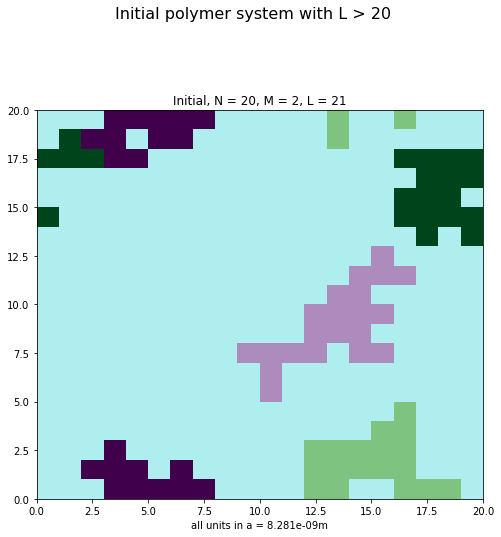

In [80]:
N = 20
M = 2
L = 21

grid_poly_1 = createSystemOfPolymers(N, M, L)
grids = [grid_poly_1]
info = [["Initial"], [0], [M], [0], [L],[False],[True]]
plotSystems(grids, info, f"Initial polymer system with L > 20")

To be able to do Monte Carlo simulations for polymer system, we need to extend our energy function and make it possible for polymers to move freely around in a grid. We will starte by implementing a function which moves polymers in a rigid fashion. 

While programming the code, we have to keep in mind that only monomers from different polymers will contribute to the energy level. We will keep the condition saying monomers have to be nearest neighbours. 

Following is the modified energy function and the function moving the polymers.

In [8]:
@jit(nopython=True)
def inArray(arr, obj):                                                                          #Function check whether or not an array with length 
                                                                                                #two is contained in a 2D array
    inArr = False                                                                               #Initial assumption: object not in array.
    for pos in arr:                                                                             #Iterating through every array containd in the array of interest 
        if np.array_equal(pos, obj):                                                            #returning True if the object is equal to a specific position in the array of interest
            inArr = True
    return inArr


@jit(nopython=True)
def totalEnergyPolymerSystem(grid):                                                             
    energy = 0                                                                                  #initial energy set to 0
                                                            
    non_zero_indexes = np.argwhere(grid)                                                        #finding coordinates of all nonzero entries of the grid

    for i in range(len(non_zero_indexes)):                                                      
        neighbours =  findNeighbours(len(grid), non_zero_indexes[i][0], non_zero_indexes[i][1]) #Creating an array containg the neighbouring positions of each of the different monomers in the grid

        for j in range(len(non_zero_indexes)):                                                  #iterating through each of these neighbouring positions 

            if inArray(neighbours, np.array([int(non_zero_indexes[j][0]), int(non_zero_indexes[j][1])])) and np.not_equal(grid[int(non_zero_indexes[i][0])][int(non_zero_indexes[i][1])], grid[int(non_zero_indexes[j][0])][int(non_zero_indexes[j][1])]):
                energy += np.sign(grid[int(non_zero_indexes[i][0])][int(non_zero_indexes[i][1])] * grid[int(non_zero_indexes[j][0])][int(non_zero_indexes[j][1])])                      #If the neighbouring location contains a monomer from another polymer,
                                                                                                                                                                                        #the energy is affected per usual                        
    return energy * alpha_poly / 2 #Dividing by 2 to cancel out overlap

@jit(nopython=True)
def rigidMove(k, direction, grid):                                         
    newGrid = grid.copy()                                                   #Making a copy of the system
    isolatedGrid = np.zeros((N,N))                                          #initializing an empty grid 
    locationOfMonomers = np.argwhere(grid)                                  #Creating an array containg the locations of evert monomer in the system

    for y, x in locationOfMonomers:                                         #Running through every location in the array of occupied locations
        if grid[y, x] == k:                                                 #Moving all of the monomers belong to polymer with number k into isolatedGrid,
            newGrid[y, x] = 0                                               #whilst removing them from the initial grid
            isolatedGrid[y, x] = k

    if direction == 0: #right                                               #For each of the four directions we move the polymer in the isolatedGrid
        for i in range(len(isolatedGrid)):
            isolatedGrid[i] = np.roll(isolatedGrid[i], 1)

    if direction == 1: #left
        for i in range(len(isolatedGrid)):
            isolatedGrid[i] = np.roll(isolatedGrid[i], -1)

    if direction == 2: #down
        isolatedGrid2 = np.transpose(isolatedGrid)
        for i in range(len(isolatedGrid2)):
            isolatedGrid2[i] = np.roll(isolatedGrid2[i], 1)
        isolatedGrid = np.transpose(isolatedGrid2)

    if direction == 3: #up
        isolatedGrid2 = np.transpose(isolatedGrid)
        for i in range(len(isolatedGrid2)):
            isolatedGrid2[i] = np.roll(isolatedGrid2[i], -1)
        isolatedGrid = np.transpose(isolatedGrid2)

    isolatedMonomers = np.argwhere(isolatedGrid)                            #Creating a list containg the occupied coordinates of the isolated grid, i.e the loactions of the polymer ofter the move

    allowedMove = True                                                      #The move is legal is the initial assumption

    for y, x in isolatedMonomers:                                           #Checking whether or not every monomer of the polymer moves to an empty location in the grid
            if newGrid[y, x] != 0:                                          #If a monomer is placed upon another after the move, the move is not allowed
                allowedMove = False
                break
    
    if allowedMove == True:                                                 #If the move is allowed the function returns a grid with the polymer being moved
        isolatedGrid = isolatedGrid.astype(np.int64)                        #If not the function returns the old grid
        return newGrid + isolatedGrid
    else:
        return grid


The extended energy fucntion, totalEnergyPolymerSystem(grid), takes the grid which we are examining as input. The only modification done to the energy function is an additional requirement in the if statement. The extra requirement is to make sure there is no interaction between monomers belonging to the same polymer. This is done by using the numpay.not_equal() function, which takes two arrays and returns True if they are not the same. In the above case the function is done to check whether or not the values of the neighbouring monomer is different or not. If they are different the numpay.not_equal() returns True and the energy is affected per usual. 

rigidMove(k, direction, grid) takse three arguments, which one of the polymers that is supposed to move, $k$, in which direction the polymer should move, and the grid we are considering. The function starts of by copying the initial grid, creating an empty grid of size $N \times N$ and using numpay.argwhere() to make an array containg the locations of every occupied position in the grid.

From here the algorithem runs through every set of coordinates in occupied in the grid and removes the ones which value is equal to $k$. Each of these locations will then be updated in the empty grid, i.e the function transfers the polymer of number $k$ from the system into the empty grid. 

Further the algorithem uses numpay.roll() to move the polymer in the different directions. Usualy numpay.roll() is able to move the elements in the grid along all axis of the array. However this argument is not supported by Numba, so in the cases were the polymer is moving up or down, the system needs to be transposed before numpay.roll() is used to move the polymer in the given direction.

When the polymer is moved, the algorithem creates an array containg the locations of the polymer after the given move. From here the function runs through each of the new locations the polymer is occupying and checks whether or not any of these positions is already occupied by a monomer of a different polymer. If this is the case the function returns the grid as it was before the move was initiated. However if the move is allowed the function returns the grid with the polymer being in its new position.

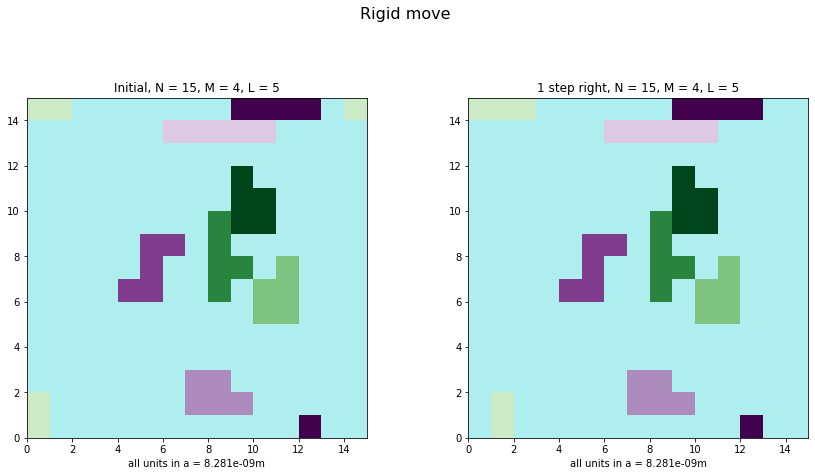

In [88]:
N = 15
M = 4
L = 5

grid_poly_1 = createSystemOfPolymers(N, M, L)
grid_poly_2 = rigidMove(1, 0, grid_poly_1)

grids = [grid_poly_1, grid_poly_2]

info = [["Initial", "1 step right"], [0,0], [M,M], [0,0], [L,L],[False,False],[True,True]]
plotSystems(grids, info, "Rigid move")

The plot showcases how the lime green polymer move the entire body one unit length to the right

# 2D

#### Monte Carlo - Rigid move
Furthermore we want to use the rigid move to run a Monte Carlo simulation for systems of polymers with the purpose that we later can investigate how the polymers of different charges behave.

We are asked to run the MC simulation with $L>10$, $2<M<6$, $T=200$. We choose the size of the grid $N$ for ourselves.
Here is our solution:

In [9]:
@jit(nopython=True)
def MC_Polymers(N_s, grid, T, move="rigid"):
    initialGrid = grid.copy()                                   #Initial grid to return
    typeMove = np.zeros(3)
    
    epsilon = np.zeros(N_s)                                     #Empty array with length N_s
    energyOfState = totalEnergyPolymerSystem(grid)              #Calculate energy for the initial grid
    epsilon[0] = energyOfState                                  #First element in energy array

    valuesOfPolymers = np.unique(grid)                          #Unique values for each polymer

    directions = np.arange(0,3)                                 #Numbered directions

    for i in range(N_s):                                        #Iterating N_s times
        k = np.random.choice(valuesOfPolymers)                  #Choosing a random polymer
        direction = np.random.choice(directions)                #Choosing a random direction
    
        oldGrid = grid.copy()                                   #Copying grid, need this if the polymers are not moving
        if move == "rigid":                                     #If move type = rigid, rigid is standard in function parameter
            newGrid = rigidMove(k, direction, grid)             #New grid with a random polymer moved a random direction using rigid move
        elif move == "flexibility":                             #If move type = flexibility
            newGrid = mediumFlexibilityMove(k, direction, grid) #New grid with a random polymer moved a random direction using medium flexibility move

        energyOfState_temp = totalEnergyPolymerSystem(newGrid)  #Calculating temporary energy of state after movement
        
        if energyOfState_temp < energyOfState:                  #If energy after movement is lower than before movement. This is the most desirable movement.
            grid = newGrid.copy()                               #Confirming movement, using this for the next MC step
            energyOfState = energyOfState_temp                  #Confirming energy
            typeMove[0] += 1

        elif np.random.random() < np.exp(- (1 / (Boltzmann * T)) * (energyOfState_temp - energyOfState)):
                                                                #Probability of making the move even if it does not achieve lower energy.
            grid = newGrid.copy()                               #Confirming movement, using this for the next MC step   
            energyOfState = energyOfState_temp                  #Confirming energy
            typeMove[1] += 1

        else:
            grid = oldGrid.copy()                               #Cancels movement, setting next grid equal to previous grid
            typeMove[2] += 1

        epsilon[i] = energyOfState                              #Fills empty energy array with calculated energy for this MC step
    
    return grid, epsilon, typeMove                              #Returing grid after N_S steps and energy development array


The MC_Polymers function takes inn how many $N_s$ steps to perform, an initial polymer grid, and which type of movement. Standard is set to rigid.
We use our previous size if $N=20$, as this is not too small such that there is no free moving space, as well as it is not too big for them not to reach eachother.
The first part of this function is initializing. We use .copy() to create a copy of the initial grid and we create a list of arrays of length $N_s$ which will be filled with calculated energy for each MC step. This will be used to plot the energy development after $N_s$ steps. We calculate the initial energy of the grid and add this to our energy array. Numpys function unique is used to get each unique value for the polymers, in order that we can choose which polymer to move. We also create an array with numbered directions in the order: right, left, up, down.

In the next part we will iterate $N_s$ times, where it for each step tests if the move is desireable.  first choose a random value $k$ and direction along with the rigid move to create a grid with a moved polymer. Secondly we calculate the temporary energy and check if the energy has lowered, this is the most desired move considering that lower potential energy is more stable. If this is the case, the grid will be updated with the desired move. If not, there is still a possibility that it will move towards a unfavorable direction, expressed as:
$$p < e^{- \frac{\Delta E}{k_B T}}$$
where $p$ is a random number between $0$ and $1$. This move is then realized, thus updating the next grid and energy element. If this is not the case either the polymers will not move and the grid stays the same, hence use the old grid. The energy element is then added to the energy array. Finally the function returns an array after repeating this process $N_s$ times together with the energy development.

This is a run of our MC polymers after 30000 MC steps

It took  278.4552791118622
It took  2.6131229400634766


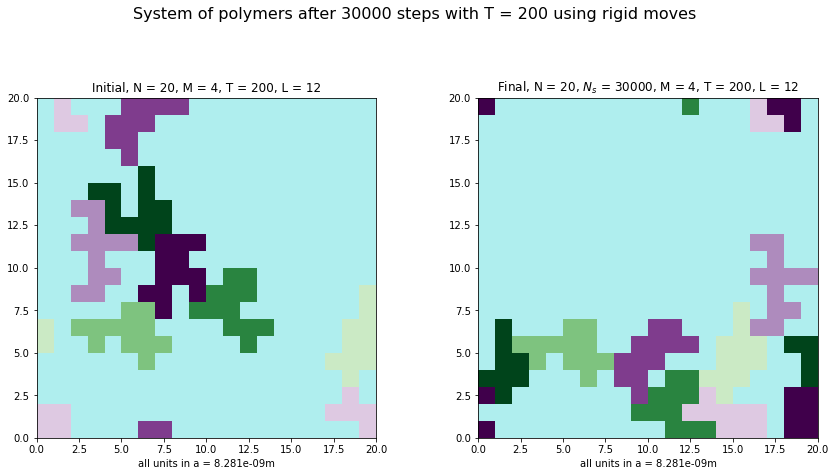

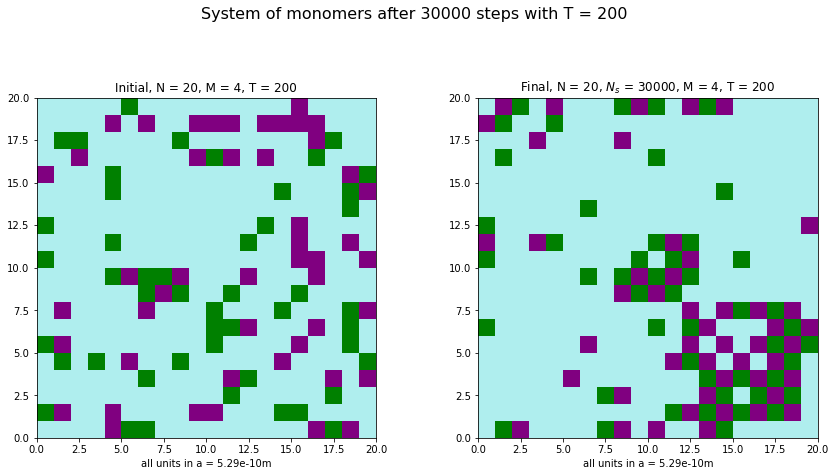

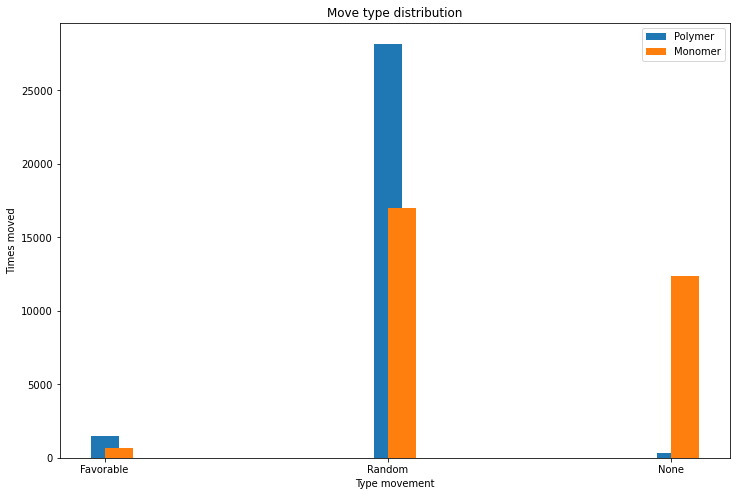

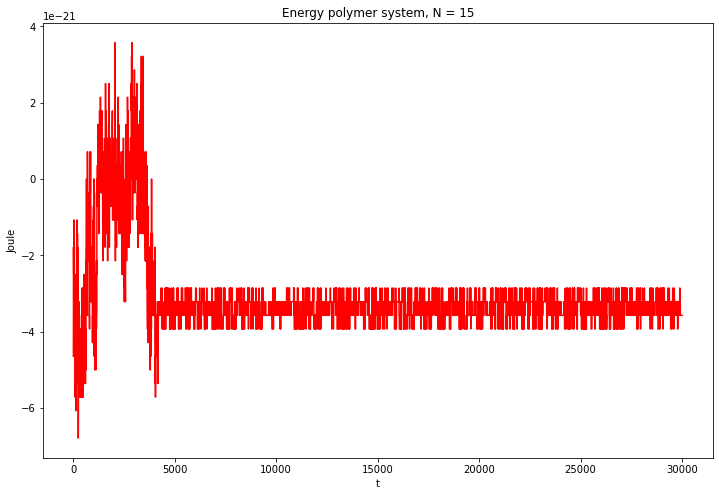

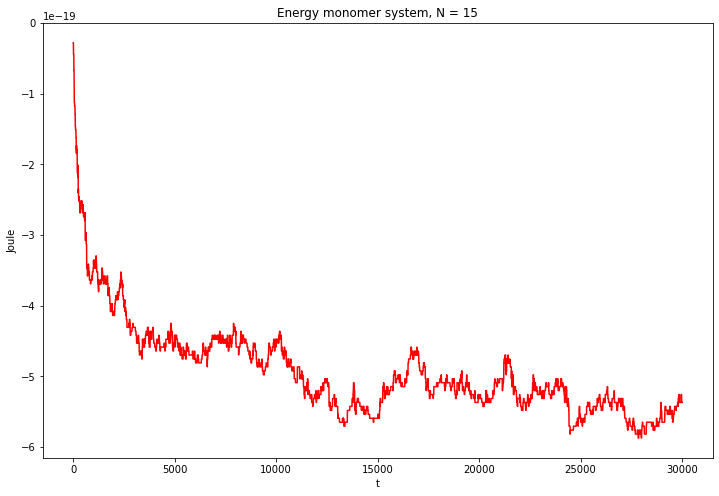

In [90]:
N_s = 30000
N = 20
M = 4
L = 12
T = 200

#MC POLYMER
start = time.time()
initial_grid_poly = createSystemOfPolymers(N, M, L)
grid_poly, epsilon_poly, type_move_poly = MC_Polymers(N_s, initial_grid_poly, T)
print("It took ", time.time() - start)

#MC MONOMER
start = time.time()
grid_mono, epsilon_mono, initial_grid_mono, type_move_mono = MC(N_s, N, 48, T)
print("It took ", time.time() - start)

grids_poly = [initial_grid_poly, grid_poly]
info_poly = [["Initial", "Final"],[0, N_s],[M, M],[T, T],[L, L],[False, False],[True, True]]
plotSystems(grids_poly, info_poly, f"System of polymers after {N_s} steps with T = {T} using rigid moves")

grids_mono = [initial_grid_mono, grid_mono]
info_mono = [["Initial", "Final"],[0, N_s],[M, M],[T, T],[0, 0],[False, False],[False, False]]
plotSystems(grids_mono, info_mono, f"System of monomers after {N_s} steps with T = {T}")

plt.figure(figsize=(12,8))
plt.title("Move type distribution")
plt.bar(["Favorable","Random","None"],type_move_poly, width=0.1, align="center", label="Polymer")
plt.bar(["Favorable","Random","None"],type_move_mono, width=0.1, align="edge", label="Monomer")
plt.legend()
plt.xlabel("Type movement")
plt.ylabel("Times moved")
plt.show()

plotEnergy(epsilon_poly, "Energy polymer system")
plotEnergy(epsilon_mono, "Energy monomer system")


The polymers will arrange eachother in the most energetically favorable position. That is, positive polymers connected with negative polymers, with as many contact surfaces as possible. With higher temperatures, the polymers will not necessarily move towards a lower energy state due to thermal fluctations and the result is that they are separated to a greater extent.

We have plotted the move type distribution, and the random move is the most dominant for both the MC polymer and monomer. There is though a big difference between 

By timing the code, we get $278$ and $3$ seconds for polymer and monomer respectivly. This with 300000 iterations. This huge difference in run time might be caused by how a rigid move is executed. The rigid move iterates through every monomer in the given polymer, and has more values to update in the new grid. Therefore, every MC-step has a longer run time, which is adding up when having $30000$ iterations. 

With the  bar chart one could expect minor difference since there are a lot of illeagel moves. The 

# 2EF

The more flexible movements we are able to implement the more realistic is the simulations we are able to run. Therefore we needed to create a more flexibile type of movement for the polymers. We wanted to implement a move with medium flexibility, that is a function that moves every monomer in the polymer in the same horizontal (vertical) direction, but if there exist any monomer in a row (column) that is not able to move, the entire row (column) stays in place. To make this a viable movement we also needed a function to check wheter or not a polymer is broken. Both of these functions can be veiwed in the cell below.

In [10]:
@jit(nopython=True)
def isBroken(grid, N, k):
    isolatedGrid = np.zeros((N,N))                                                          #Initializing empty grid of size NxN
    locationOfMonomers = np.argwhere(grid)                                                  #Creating array containg locations of monomers in the grid

    m = 1                                                                                   
    for y, x in locationOfMonomers:                                                         #Moving each monomer which is part of the given polymer into the empty grid and assigning
        if grid[y, x] == k:                                                                 #each one with an unique positive integer
            isolatedGrid[y, x] = m
            m += 1

    clusterGrid, numberOfClusters, sizes = cluster(isolatedGrid, N, 0)                      #using the cluster function to return the amount of clusters in the grid containg the polymer of interest
    if numberOfClusters > 1:                                                                #Checking whether or not the grid containg the polymer contains more than one cluster.
        return True                                                                         #Return true if the polymer is broke
    else:
        return False

@jit(nopython=True)
def mediumFlexibilityMove(k, direction, grid):                                      
    N = len(grid)                                                                           #Defining the grid size N
    newGrid = grid.copy()                                                                   #Copying the grid
    isolatedGrid = np.zeros((N,N))                                                          #Initializing a en empty grid of size NxN
    locationOfMonomers = np.argwhere(grid)                                                  #Array containg every nonzero location in the grid 

    for y, x in locationOfMonomers:                                                         #Moving the polymer of interest into the isolated grid, whilst removing it from the grid given as input
        if grid[y, x] == k:
            newGrid[y, x] = 0
            isolatedGrid[y, x] = k

    if direction == 0: #right                                                               #Seting the parameter a = +-1 given the direction of movement
        a = 1
    
    if direction == 1: #left
        a = -1

    if direction == 2: #down                                                                #Needing to transpose the grid in cases of movement in the second axis
        a = 1
        isolatedGrid = np.transpose(isolatedGrid)
        newGrid = np.transpose(newGrid)

    if direction == 3: #down
        a = -1
        isolatedGrid = np.transpose(isolatedGrid)
        newGrid = np.transpose(newGrid)

    locationOfMonomersOnLine = np.argwhere(isolatedGrid)                                     #creating a list of locations of monomers in the isolated grid
    
    for i in range(len(isolatedGrid)):                                                       #Tony forklar 
        move = True
        for j in range(len(isolatedGrid[i])):
            if not move:
                break
            for l in range(len(locationOfMonomersOnLine)):
                if np.array_equal(locationOfMonomersOnLine[l], np.array([i,j])):
                    if newGrid[i,(j + a)%N] != 0: #
                        move = False
                        break
        if move:
            isolatedGrid[i] = np.roll(isolatedGrid[i], a)
                
    if direction == 2 or direction == 3:
        isolatedGrid = np.transpose(isolatedGrid)
        newGrid = np.transpose(newGrid)

    allowedMove = True

    if isBroken(isolatedGrid,N,k):
        allowedMove = False 

    if allowedMove == True:
        return newGrid + isolatedGrid
    else:
        return grid

isBroken(grid, N, k) takes three inputs, the grid in whcih the movement is happening, the grid size N and the polymer of interest, k. In the same manner as the function rigidMove() this function starts off by initiating an empty grid of size NxN and creates an array containg the locations of the monomers in the system. Furthermore the function moves every location in the grid which is occupied by a monomer in polymer k to the isolated grid. All of these monomers is assigned a unique positive integer. From here the function cluster is used to return the amount of clusters there is in the isolated grid. If the amount of clusters are more than one the funstion returns True, since the polymer is broken. If the amount of clusters equal one, the function returns False.


mediumFlexibilityMove(k, direction, grid) takes in the usual $k$, direction and grid to copys the grid to save the initial. By iterating through the grid, it deletes the polymer from the new grid while putting them int an isolated grid, where every other entry is $0$. By Numba restrictions, np.roll can only roll 1D-arrays sideways, making the function transpose the matrix for up and down movement. Then iterating though every row/column then every monomer, the function checks if the "next square" is occupied or not. If any monomer fail, the entire for-lopo for the row/column breaks before starting a new line. Lastly, by isBroken(), it checks if the move is allowed or not, returning the initial grid. If a move suceeds, the function adds the isolated grid with the new grid and return the updated posistions. 

To see what kind of impact the felxible move has on our Monte Carlo simulations, we ran two different simulations on the same initial grid, one with the rigid move and one with the medium flexible move. Furthermore, we plotted the total energy of the systems as a function of time in the same plot. The plots of interest is seen below.

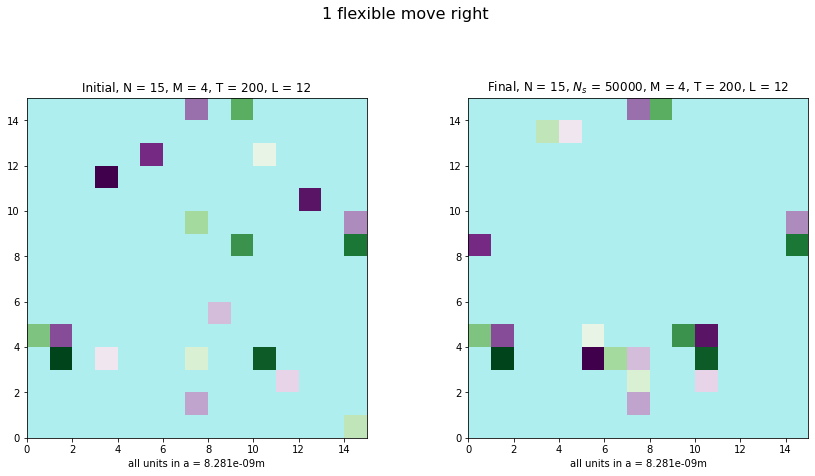

In [60]:
N_s = 50000
N = 20
M = 4
L = 12
T = 200

#initialGrid = createSystemOfPolymers(N, M, L)

grid = mediumFlexibilityMove(2, 2, grid)


grids = [initialGrid, grid]
info = [["Initial", "Final"],[0, N_s],[M, M],[T, T],[L, L],[False, False],[True, True]]
plotSystems(grids, info, "1 flexible move right")

The plot showcases the lightgreen polymer moving flexible to the right. 

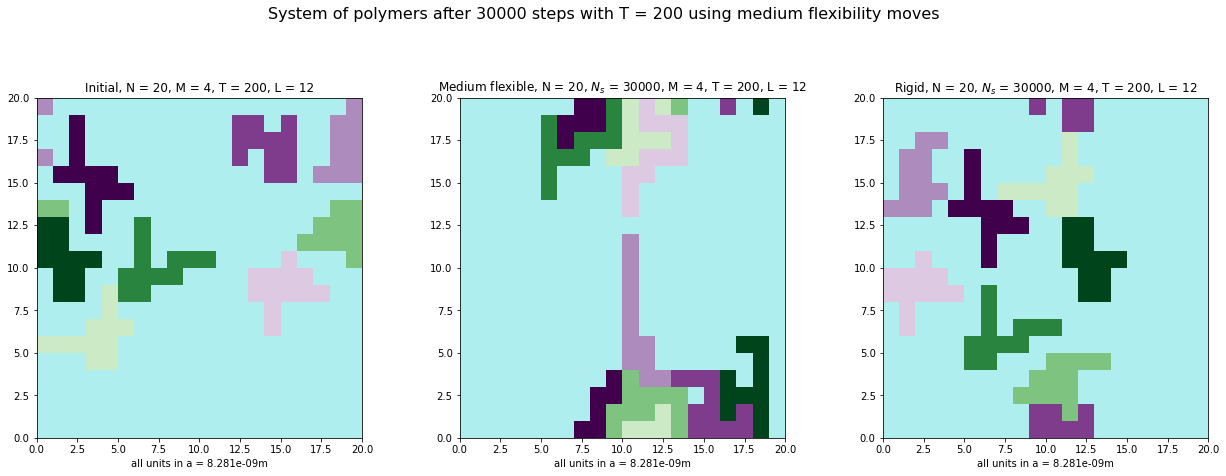

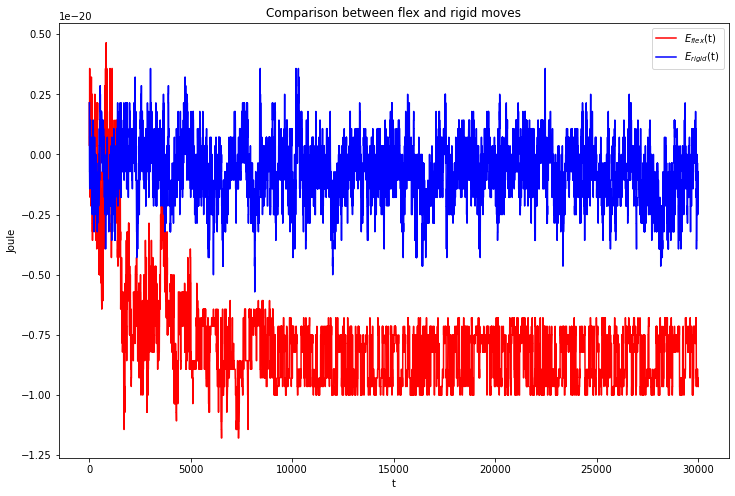

It took:  336.9032392501831 seconds


In [93]:
N_s = 30000
N = 20
M = 4
L = 12
T = 200

initialGrid = createSystemOfPolymers(N, M, L)

start = time.time()

grid_flex, epsilon_flex, typeMove = MC_Polymers(N_s, initialGrid, T, move = "flexibility")
grid_rigid, epsilon_rigid, typeMove = MC_Polymers(N_s, initialGrid, T, move= "rigid")


grids = [initialGrid, grid_flex, grid_rigid]
info = [["Initial", "Medium flexible", "Rigid"],[0, N_s, N_s],[M, M, M],[T, T, T],[L, L, L],[False, False, False],[True, True, True]]
plotSystems(grids, info, f"System of polymers after {N_s} steps with T = {T} using medium flexibility moves")

plotEnergy(epsilon_flex, "Energy polymer system", t=T, comparison=True, epsilon2=epsilon_rigid, move="flex", move2="rigid")
print("It took: ", time.time() - start, "seconds")

From the plots we see that the MC-simulation running the medium felxible move formes larger clusters than the simulation using the rigid move. This is linked to the larger degree of freedom conserning the polymers ability to move around the grid. It is natural to assume that this increased ability to move is going to result in a larger ability to obtain lower states of energy for the system. This is also proven to be the case, as shown in the plot compairing the energy of the systems.  

In our last large scale Monte Carlo simulation we want to study two quantities: the mean cluster size, <d>, devidend by the multivalency, $L$, and the average numbers of clusters $\langle m \rangle$ in a grid. Both of these quantities should be functions of the parameter $L$. 

During these simulations we would like to do n meassurments of both quantities after the system has reached equilibrium. The amount of time steps needed to to reach equilibrium is assumed to follow the same model as before. To reduce the run time, but still get a resonable amount of meassurments for each of the different values of $L$, we chose to do $n = 10$ meassurments after equilibrium.

The algorithem we created to accumulate this data, is presented below.

In [14]:
def meanSizePolyEdition(initialGrid, N, T, n):
    grid = initialGrid.copy()                                                                   #copying the initial grid

    t_eq = 20000                                                                                #Computing the amount of time steps needed for equilibrium
    
    grid_eq, epsilon_eq, initialGrid = MC_Polymers(t_eq, grid, T, move = "rigid")               #Using monte carlo to obtain a system in equilibrium

    grid_i = grid_eq

    meanDOfL = list()                                                                           #initiating the lists in which the mean values are appended
    meanNumberOfClusters = list()                                                               
    for i in range(n):                                                                          #Doing meassurments after t_r steps, n times
        grid_i, epsilon_i, initialGrid = MC_Polymers(t_r, grid_i, T, move = "rigid")

        clusterGrid, numberOfClusters, sizes = cluster(grid_i, N, 0)

        meanDOfL.append(sum(sizes)/numberOfClusters)
        meanNumberOfClusters.append(numberOfClusters) 
    
    return mean(meanDOfL), mean(meanNumberOfClusters)                                           #returning the mean cluster size and the average number of clusters in the grid

def functionsOfL(N, M, L, T):
    dOfL = np.zeros(len(L))                                                                     #initializing arrays in which the data of interest is added
    mOfL = np.zeros(len(L))

    for i in range(len(L)):                                                                     #Doing meassurments for each value of L
        print(i)
        grid = createSystemOfPolymers(N, M, L[i])

        meanDOfL, meanNumberOfClusters = meanSizePolyEdition(grid, N, T, n)

        dOfL[i] = meanDOfL/L[i]
        mOfL[i] = meanNumberOfClusters

    return L, dOfL, mOfL                                                                        #Returning the values of interest 

meanSizePolyEdition() operates in much of the same way as the function meanSize() which finds the mean cluster size as a function of temperature.
In the polymer case the function does not iterate through a series of temperatures, since the change of temperature is not of interest. Hence the functions only for-loop is used to do n meassurments of both the mean cluster size and the average amount of clusters.

functionsOfL() uses meanSizePolyEdition() to create an array containing the mean cluster size devided by L, as well as the average amount of clusters in the grid, both as functions of L.

The two quantities is ploted below.

In [15]:
plot = True
if plot == True:
    T = 300
    t_r = 500
    N = 30
    M = 5
    L = np.linspace(3, 39, 13).astype(np.int64)
    n = 10

    L, dOfL, mOfL = functionsOfL(N, M, L, T)


0
1
2
3
4
5
fail
6
7
fail
8
9
fail
fail
10
11
12


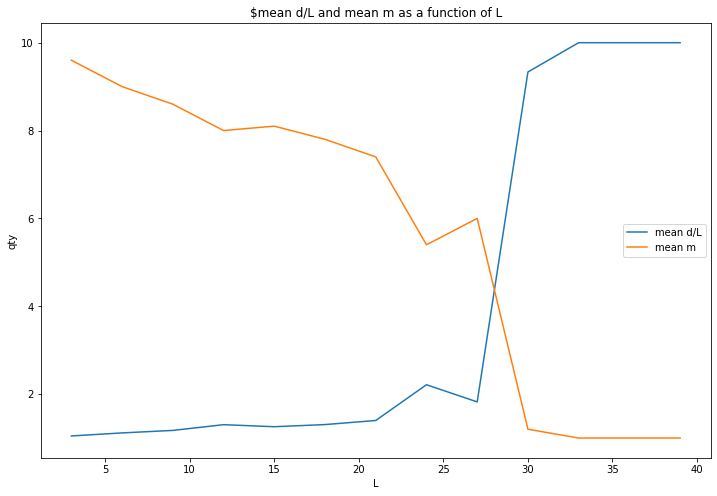

[10.05333333 10.05       10.09134921 10.43174603 10.18607143 10.18952381
 10.35412698 11.95285714 10.93333333 11.2        10.         10.
 10.        ]


In [28]:

plt.figure(figsize=(12,8))
plt.title("$mean d/L and mean m as a function of L")
plt.plot(L, dOfL, label="mean d/L")
plt.plot(L, mOfL, label="mean m")
plt.xlabel("L")
plt.ylabel("qty")
plt.legend()
plt.show()
print(dOfL * mOfL)

We expect some kind of inverse proportional correlation between $\frac{\langle d \rangle}{L}$ and $\langle m \rangle$. We include some rigorous proofs on why. 

We have shown earlier that $\langle d \rangle$ esimates $d$ which is given by an average, namely $\frac{1}{n} \sum d_i$. Here $n$ is the number of clusters, that is $m$, and $d_i$ wil always sum up to all monomers, $2ML$, meaning. 

$$ \langle d \rangle = \frac{1}{n} \sum_{i=1}^n d_i = \frac{2ML}{m} $$

Rearranging we get

$$ \frac{\langle d \rangle m}{L} =   2M $$

Meaning the expected product of $\frac{\langle d \rangle}{L}$ and $\langle m \rangle$ is constant. and our claim follows. 

Our plots seems to illustrate this relation quite well, whilst one are increasing the other is decreasing and vice verse. Also their product gives an good estimate for $2M$. The deviation is due to $\langle m \rangle \neq m$ all empiric sample spaces. 

**Sicke ord**

Chaos
inconsistency
simultaneously

**Scrap**

1F
The following plots presents the results of our first Monte Carlo simulations. We ran two simulations each for a different temperature, T_1 = 200 K and T_2 = 500 K. The purpose of the simulations were to compare how the energy of a system behaves as a function of time for the different temperatures. Furthermore we used the same initial grid for both simulations to create a better basis for comparison. The numerical values for the different parameters of the metropolis algorithem is listed in the cell below.

1f
From the above plots we can derive by visual consideration the amount of Monte Carlo steps needed to reach equilibrium for each of the given temperatures. For T_1 = 200 K t_equili seems to be around 20 000 MC-steps, whilst considering T_2 = 500 K t_equili is about 2 000 MC-steps. 

These observations can be explaiend by...

1g)
The practicale implementation of the law of conservation of energy is the formation of aggregates in the system, that is, the clustering of monomers*. To reduce the overall energy of the system, monomers of opposite charges go together to create structures where there are as few equaly charged monomers side by side as possible. In our first large scale Monte Carlo simulation we want to observe how the mean cluster size behave as a function of temperature.

To execute these simulations we needed an efficient algorithem to create a grid where every monomer in the same cluster is represented by the same positive integer. This function is presented below.

e wanted to meassure the mean cluster size of systems for different temperatures, after equilibrium is obtained n times. For larger temperatures the amount of time steps required to reach equilibrium is severilly reduced compared to smaller temperatures.

Now we want to run 10 consecutive simluations with different temperatures to find cluster size as a function of temperature.

**Plotting $\langle d\rangle$**

As we have discused before, a freezing enviroment will fluxuate around a low energy state. Opposite neighbour charges gives the highest negativ energy contribution, meaning monomers is merged together like a chess board grid. Such systems will only have a few such blobes, meaning the cluster sizes will be enermous.

We are expecting a mononotic decrease in $\langle d \rangle$ since higher temperatures will make monomers deviante from the grid. Our graphs illustraed our presumption quite well. However, in our plots, there might be a little dent. Our suspicion is that systemes are not independent enough after $t_r=1000$. A "bad" system of monomers, where say every monomer are grouped together, might give 10 equally skewed samples, making a dent in our graph

In the beginning part of this project we wanted to run large scale Monte Carlo simulations on simplified monomer systems. Therfore we needed efficient algorithmes to both initiate such grids of monomers, as well as visualizing them in an adequate way. To shorten the run time of our simulations, we were using built in functions of the NumPy library. These go well with the Numba library, which gave us access to the opportunity to use jit to further boost our computational efficiency.

The algorithems we implemented for these purposes is presented below.

**What is a good sample space**

For our system, it might be hard to define a "good" sample space, especially since our samples are semidependet. We chose our sample space to be $n=10$. By the smoothness of the graph, corresponding to our expectations, we will consider this plot realistic. 

**CreateSystemOfPolymers**

When considering our code, there is a slight probability that createSystemOfPolymers() will run indefinitely. Big clusters of polymers may cage in sectors such that new polymers lack spaces to fully forge. Our while-lopp will always try to find a legal space to expand. However, if there are none, this loop will continue forever. This is a minor flaw that we are aware of. Thus far, it has caused close to no problem. If $M,L$ were relatively large compared to $N$, this would be a serious concern. However, our initial values have proven compatible with our code.

In [52]:
a = np.array([[0, 1, 2],
              [0, 2, 4],
              [0, 3, 6]])
print(a)

print(np.where(a != 1, a, 2))

[[0 1 2]
 [0 2 4]
 [0 3 6]]
[[0 2 2]
 [0 2 4]
 [0 3 6]]


**Why system looks the way it does**

As in the case of monomers, polymers will cluster together to make a huge blob. The final grid showcases few clusters where opposite charges are neighboring. The system is constantly trying to decrease its energy level. In the final grid we see that polymers with opposite charge are neighbouring, making in the system energy minimal. For the rigid move, all polymers keep their initial shape, leaveing quite a few holes inbetween polymers. Most likely there are configurations with lower energy, but comprehensive relocations are required to achive such states. 